In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

In [27]:
columns = ['user_id', 'order_date', 'order_product_number', 'order_total_amount']
df = pd.read_table('trans_details.txt', names = columns, sep = '\s+')

In [28]:
df.head()

,user_id,order_date,order_product_number,order_total_amount
0,1,20170101,1,11.77
1,2,20170112,1,12.00
2,2,20170112,5,77.00
3,3,20170102,2,20.76
4,3,20170330,2,20.76


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69659 entries, 0 to 69658
Data columns (total 4 columns):
user_id                 69659 non-null int64
order_date              69659 non-null int64
order_product_number    69659 non-null int64
order_total_amount      69659 non-null float64
dtypes: float64(1), int64(3)
memory usage: 2.1 MB


* no missing data
* "order_date" type should be converted to datetime

In [30]:
df.describe()

,user_id,order_date,order_product_number,order_total_amount
count,69659.000000,6.965900e+04,69659.000000,69659.000000
mean,11472.050273,2.017228e+07,2.410040,35.894050
std,6821.353964,3.837735e+03,2.333924,36.283768
min,1.000000,2.017010e+07,1.000000,0.000000
25%,5506.000000,2.017022e+07,1.000000,14.490000
50%,11410.000000,2.017042e+07,2.000000,25.980000
75%,17273.000000,2.017111e+07,3.000000,43.700000
max,23570.000000,2.018063e+07,99.000000,1286.010000


### Some simple consequences from the summarized table：
* Total number of users is **23570**;
* User' consumpotion date are between **2017-01 and 2018-06**;
* 75% "order_total_amount" is 43.70, the median is 25.98 that is lower than the mean (35.89) so that we know it's a **long tail module** (positive skewness) It obeys the **Pareto Rule** that the smaller portion of orders contribute to the majority of "order_total_amount".

Convert string to datetime and extract "month_year"

In [31]:
df['order_date'] = pd.to_datetime(df['order_date'], format = '%Y%m%d')
df['month_year'] = pd.to_datetime(df['order_date']).dt.to_period('M')

The granularity of original dataset is **Order**. What if I review the data from **User** perspective? 

In [32]:
user_based = df.groupby('user_id').sum()
user_based.describe()

,order_product_number,order_total_amount
count,23263.000000,23263.000000
mean,7.216653,107.481564
std,17.119566,242.861319
min,1.000000,0.000000
25%,1.000000,19.990000
50%,3.000000,43.810000
75%,7.000000,108.720000
max,1033.000000,13992.930000


* Similar to the performance of **Order** -- Long tail module (Pareto Rule)

## Visualization

### From Month_Year perspective: general trend 

Text(0,0.5,'order_total_amount')

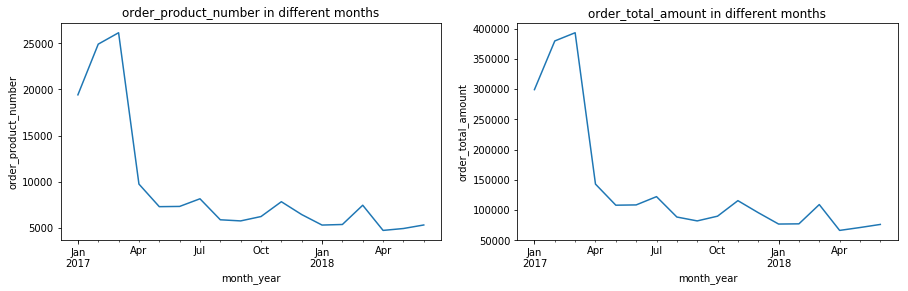

In [33]:
plt.figure(figsize=(15, 4))

plt.subplot(121)
df.groupby('month_year').order_product_number.sum().plot()
plt.title('order_product_number in different months')
plt.ylabel('order_product_number')

plt.subplot(122)
df.groupby('month_year').order_total_amount.sum().plot()
plt.title('order_total_amount in different months')
plt.ylabel('order_total_amount')

Given plots, whatever the trend of order_product_number or that of order_total_amount(sales), the first-three-month data are abnormal. There are many reasons leading to this situation.(Need to dig in depth)

### From User perspective: relationship, distribution, time 

Text(0.5,1,'Relationships of order_total_amount in different months')

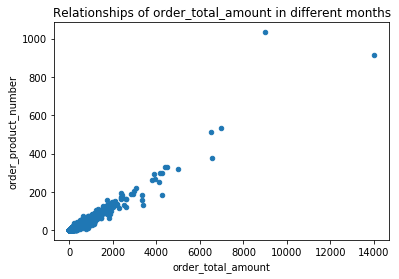

In [34]:
df.groupby('user_id').sum().plot.scatter('order_total_amount', 'order_product_number')
plt.title('Relationships of order_total_amount in different months')

Except for the significant outlier at the top, other points shows that there is a strong positive correlation between order_total_amount and order_product_number. It's reasonable since nourishments are usually in a steady price.

(0, 1400)

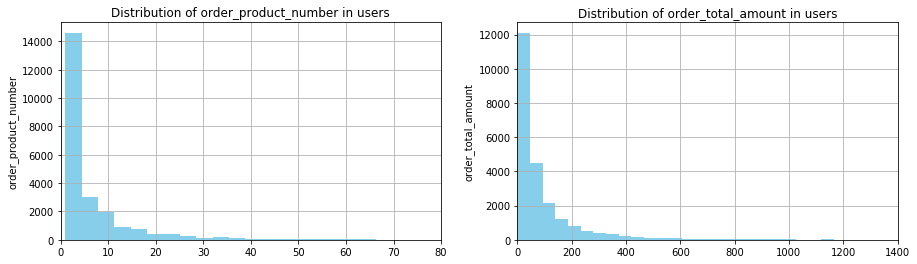

In [35]:
plt.figure(figsize=(15, 4))

plt.subplot(121)
df.groupby('user_id').order_product_number.sum().hist(bins = 300, color = 'skyblue')
plt.title('Distribution of order_product_number in users')
plt.ylabel('order_product_number')
plt.xlim(0,80)

plt.subplot(122)
df.groupby('user_id').order_total_amount.sum().hist(bins = 300, color = 'skyblue')
plt.title('Distribution of order_total_amount in users')
plt.ylabel('order_total_amount')
plt.xlim(0,1400)

From the distribution graphs, we can see that most of customers don't have strong purchasing power that number of products is lower than 20 and total amount of products is samller than 200. We can rarely see high-valued customers.This phenomenon is the reflection of general economic rules.

Now, let's see consumption behavior in a specific period:
* We want to find what is the first time for customers to buy nourishment
* As well as months that show last purchase records 

In [36]:
df.groupby('user_id').month_year.min().value_counts()

2017-02    8443
2017-01    7810
2017-03    7010
Freq: M, Name: month_year, dtype: int64

In [37]:
df.groupby('user_id').month_year.max().value_counts()

2017-02    4882
2017-03    4302
2017-01    4164
2018-06    1506
2018-05    1040
2018-03     988
2018-04     769
2017-04     671
2017-12     616
2017-11     600
2018-02     545
2018-01     512
2017-07     487
2017-06     485
2017-05     471
2017-10     452
2017-09     393
2017-08     380
Freq: M, Name: month_year, dtype: int64

## Story behind the data
We can see that the first purchase for each user happens at the first three months and most of users' last pruchase records are the first three months too. Thus, it infers that **this dataset records customers who buy nutruishment in these three months and tracks their following purchase data**, which is also a reasonable explanation why the first-three-month data is abnormal.

In this dataset, there are some customers who only have one purchase record and their first record is equal to their last one, which means we "lost" these customers

## Re-purchase Rate Per Month
Definiation: number of users who have second purchase records in a spercific time bucket (month) / total number of users

In [38]:
pivoted_counts = df.pivot_table(index = 'user_id', columns = 'month_year', values = 'order_date', aggfunc = 'count' ).fillna(0)
pivoted_counts.head()

month_year,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06
user_id,,,,,,,,,,,,,,,,,,
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0


In [39]:
# Mark 1 if x>1, 0 if x=1, Nan if x=0
pivoted_counts_trans = pivoted_counts.applymap(lambda x: 1 if x>1 else np.NaN if x == 0 else 0)
pivoted_counts_trans.head()

month_year,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06
user_id,,,,,,,,,,,,,,,,,,
1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN
4,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
5,1.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN


Text(0,0.5,'ratio/percent')

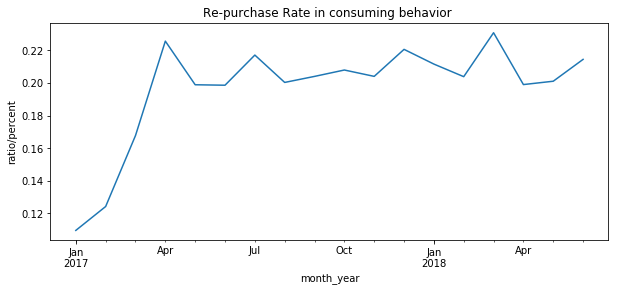

In [40]:
repurchase_rate = pivoted_counts_trans.sum()/pivoted_counts_trans.count()
repurchase_rate.plot(figsize = (10,4))
plt.title('Re-purchase Rate in consuming behavior ')
plt.ylabel('ratio/percent')

Since we know this dataset tracks purchase records of the first three month customer, there is an increasing trend in the beginning. After April, the rate is dynamically balanced at around 20%. It is not enough, and we should know the exact number of customers per month.

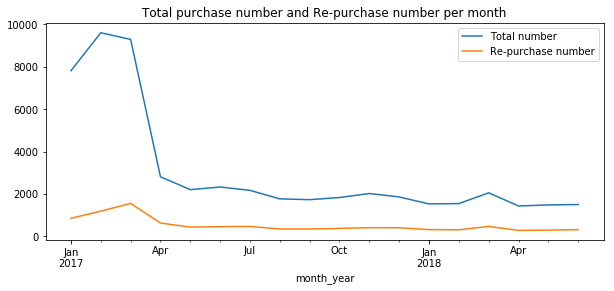

In [41]:
plt.subplots(figsize = (10,4))
pivoted_counts_trans.count().plot()
pivoted_counts_trans.sum().plot()
plt.title('Total purchase number and Re-purchase number per month')
plt.legend(['Total number','Re-purchase number'])

## Customer Segmentation: RFM Model

In [42]:
userid = df.user_id.unique()
frequency = df.groupby('user_id').count().order_date
recency = df.groupby('user_id').order_date.max()
NOW = datetime(2018,10,17)
recency = recency.apply(lambda x: (NOW-x).days)
monetory = df.groupby('user_id').order_total_amount.sum()

In [43]:
rfm_model = pd.DataFrame({'user_id': userid, 'frequency': frequency, 'recency': round(1000/recency,2), 'monetory':monetory}).set_index('user_id')
rfm_model.head() #convert recency to 1000/recency in order to keep same trend as frequecy and monetory: larger => better

,frequency,recency,monetory
user_id,,,
1,1,1.53,11.77
2,2,1.56,89.00
3,6,7.04,156.46
4,4,3.24,100.50
5,11,3.48,385.61


Determining RFM Quartiles


In [44]:
quantiles = rfm_model.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()
quantiles

{'frequency': {0.25: 1.0, 0.5: 1.0, 0.75: 3.0},
 'recency': {0.25: 1.63, 0.5: 1.72, 0.75: 3.18},
 'monetory': {0.25: 19.99, 0.5: 43.81, 0.75: 108.72}}

Create segmentation table with four classes for each features

In [45]:
def segmentation(x,feature):
    if x <= quantiles[feature][0.25]:
        return 1
    elif x <= quantiles[feature][0.5]:
        return 2
    elif x <= quantiles[feature][0.75]:
        return 3
    elif x > quantiles[feature][0.75]:
        return 4

In [46]:
rfm_model['R_Quartile'] = rfm_model['recency'].apply(lambda x: segmentation(x,'recency'))
rfm_model['F_Quartile'] = rfm_model['frequency'].apply(lambda x: segmentation(x,'frequency'))
rfm_model['M_Quartile'] = rfm_model['monetory'].apply(lambda x: segmentation(x,'monetory'))

Rank of valuable customers

In [47]:
rfm_model['Classification'] = rfm_model['R_Quartile'].map(str) + rfm_model['F_Quartile'].map(str) + rfm_model['M_Quartile'].map(str)

In [48]:
rfm_model.head()

,frequency,recency,monetory,R_Quartile,F_Quartile,M_Quartile,Classification
user_id,,,,,,,
1,1,1.53,11.77,1,1,1,111
2,2,1.56,89.00,1,3,3,133
3,6,7.04,156.46,4,4,4,444
4,4,3.24,100.50,4,4,3,443
5,11,3.48,385.61,4,4,4,444


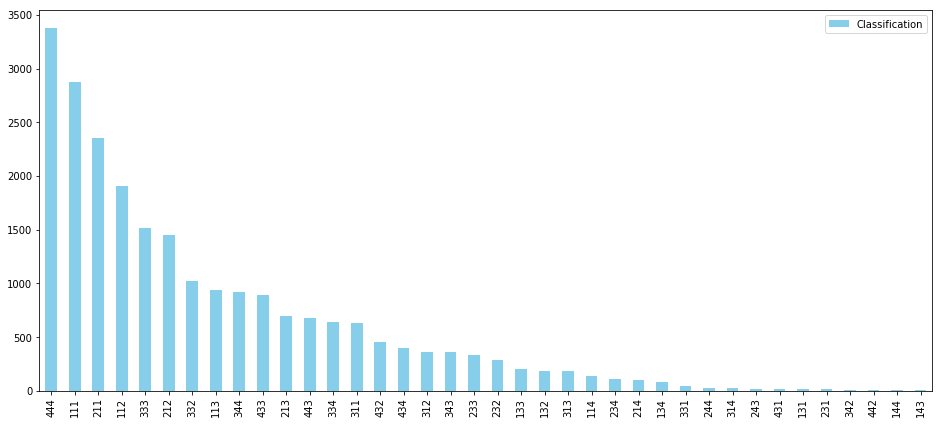

In [49]:
classCcount= rfm_model['Classification'].value_counts().to_frame()
classCcount.plot.bar(figsize=(16,7),color = 'skyblue')

Here is a general customer segmentation distribution.We can also use K-Means Clustering Algorithm to split customers and apply prediction models to find high-valued customer in advanced. What's more, content/items recommendation is another application based on customer segmentation.

## Customer Quality

Since we know that there is Pareto Rule in customer consuming habits, we should know the exact portion that high-valued customers contribute.

In [58]:
# Add a cumulative summary in order_total_amount and sort them
user_amount = df.groupby('user_id').order_total_amount.sum().sort_values().reset_index()
user_amount['amount_cumsum'] = user_amount.order_total_amount.cumsum()
user_amount.tail()

,user_id,order_total_amount,amount_cumsum
23258,7931,6497.18,2463846.60
23259,19339,6554.70,2470401.30
23260,7983,6973.07,2477374.37
23261,14048,8976.33,2486350.70
23262,7592,13992.93,2500343.63


Text(0.5,0,'number of customers')

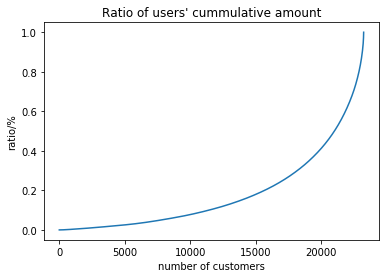

In [60]:
# Calculate ratio and plot the graph
user_amount['ratio'] = user_amount.amount_cumsum.apply(lambda x: x / user_amount.amount_cumsum.max())
user_amount.ratio.plot()
plt.title("Ratio of users' cummulative amount")
plt.ylabel('ratio/%')
plt.xlabel('number of customers')

From the graph, we can see that 15000 customers contribute to about 20% of total amount and the last 3000 customers contribute to almost 60%. The slope of this line increases extremly fast when it closes to the end so that we know we should pay more attention on the high-valued customers with specific customer care strategies.

## Customer Life Time Value: CLV Model

In [62]:
order_date_min = df.groupby('user_id').order_date.min()
order_date_max = df.groupby('user_id').order_date.max()
life_time = (order_date_max-order_date_min).reset_index()
life_time.describe()

,user_id,order_date
count,23263.000000,23263
mean,11714.868590,136 days 01:27:39.098138
std,6786.409918,181 days 03:03:30.217764
min,1.000000,0 days 00:00:00
25%,5848.500000,0 days 00:00:00
50%,11676.000000,0 days 00:00:00
75%,17523.500000,298 days 00:00:00
max,23570.000000,544 days 00:00:00


The mean LT is 136 days and the median LT is 0, which means that 50% of customers have only one purchase and we can mark them as low-valued customers. The max LT is 544 is the time bucket of this dataset, and this customer is absolutely high-valued.

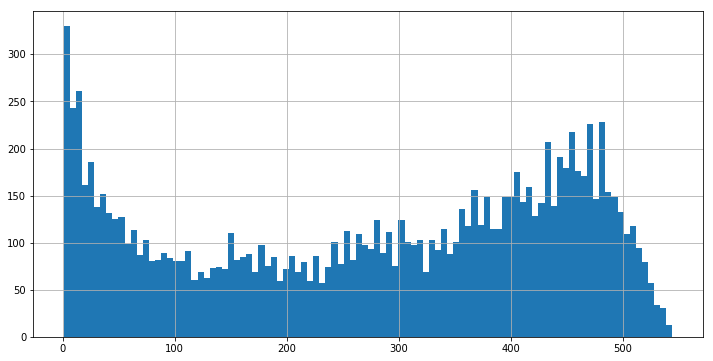

In [63]:
life_time['life_time'] = life_time.order_date/np.timedelta64(1,'D')
life_time[life_time.life_time > 0].life_time.hist(bins =100,figsize = (12,6))

It is a bi-modal distribution. We should use a proper boot method to convert the low LTV customers into a general LTV customers, who are between 50 days and 400 days. Customers whose LT are larger than 400 days are loyal customers, and we should maintain relationships with them. 

## Question: relastionship between high LTV and contributed_amount

0.17100507340389495

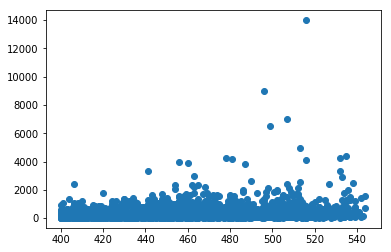

In [127]:
user_base = df.groupby('user_id')
user_group = pd.DataFrame(user_base.order_total_amount.sum())
user_group['LTV'] = (user_base.order_date.max() - user_base.order_date.min())/np.timedelta64(1,'D')
highLtv = user_group[user_group['LTV']>=400]

plt.scatter(highLtv.LTV, highLtv.order_total_amount)

highLtv.LTV.corr(highLtv.order_total_amount)

r = 0.17 so that there is no correlation between them.

## Retention Rate

In [142]:
user_base = pd.merge(left = df, right = order_date_min.reset_index(), how = 'inner', on = 'user_id', suffixes=('', '_min'))
user_base['order_date_diff'] = user_base.order_date-user_base.order_date_min
user_base['date_diff'] = user_base.order_date_diff.apply(lambda x: x/np.timedelta64(1,'D'))
user_base.head()

,user_id,order_date,order_product_number,order_total_amount,month_year,order_date_min,order_date_diff,date_diff
0,1,2017-01-01,1,11.77,2017-01,2017-01-01,0 days,0.0
1,2,2017-01-12,1,12.00,2017-01,2017-01-12,0 days,0.0
2,2,2017-01-12,5,77.00,2017-01,2017-01-12,0 days,0.0
3,3,2017-01-02,2,20.76,2017-01,2017-01-02,0 days,0.0
4,3,2017-03-30,2,20.76,2017-03,2017-01-02,87 days,87.0


In [144]:
bin = [0,30,60,90,120,150,180,365]
user_base['date_diff_bin'] = pd.cut(user_base.date_diff, bins = bin)

user_base= user_base.groupby(['user_id','date_diff_bin']).order_total_amount.sum().unstack()
user_base.head()

date_diff_bin,"(0, 30]","(30, 60]","(60, 90]","(90, 120]","(120, 150]","(150, 180]","(180, 365]"
user_id,,,,,,,
3,NaN,NaN,40.3,NaN,NaN,NaN,78.41
4,29.73,NaN,NaN,NaN,NaN,NaN,41.44
5,13.97,38.90,NaN,45.55,38.71,26.14,155.54
7,NaN,NaN,NaN,NaN,NaN,NaN,97.43
8,NaN,13.97,NaN,NaN,NaN,45.29,104.17


Text(0,0.5,'retention rate')

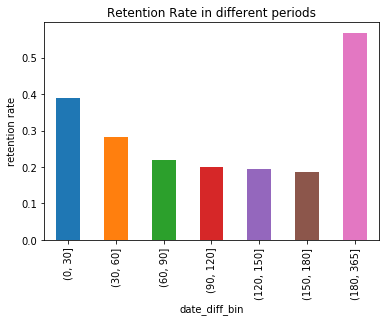

In [149]:
pivoted_retention_trans = user_base.fillna(0).applymap(lambda x: 1 if x >0 else 0)
(pivoted_retention_trans.sum()/pivoted_retention_trans.count()).plot.bar()
plt.title('Retention Rate in different periods')
plt.ylabel('retention rate')